<a href="https://colab.research.google.com/github/ganeshrohan/Stock_Price_Prediction/blob/main/stock_price_prediction_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Author - Ganesh Rohan
# Analysis of Index price prediction using regression models.
# Importing required details.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import PCA

In [ ]:
import yfinance as yf
# Download the data from Yahoo Finance
stock = yf.download("^NSEI", start='2000-01-01', end='2023-01-01')


[*********************100%%**********************]  1 of 1 completed


In [ ]:
stock

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0
...,...,...,...,...,...,...
2022-12-26,17830.400391,18084.099609,17774.250000,18014.599609,18014.599609,176700
2022-12-27,18089.800781,18149.250000,17967.449219,18132.300781,18132.300781,214300
2022-12-28,18084.750000,18173.099609,18068.349609,18122.500000,18122.500000,193900


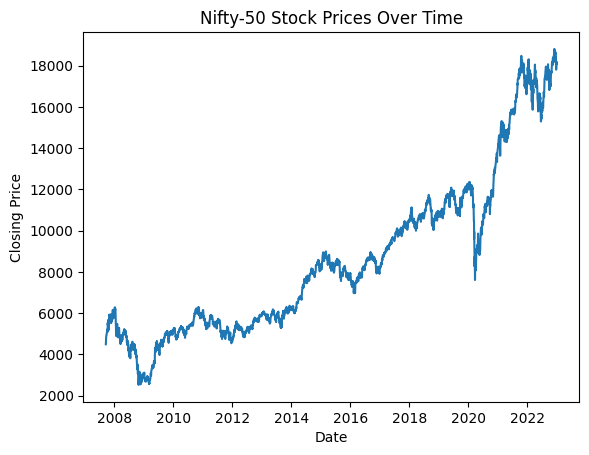

In [ ]:
# Create a line plot of stock prices over time
plt.plot(stock["Close"])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title(f"Nifty-50 Stock Prices Over Time")
plt.show()

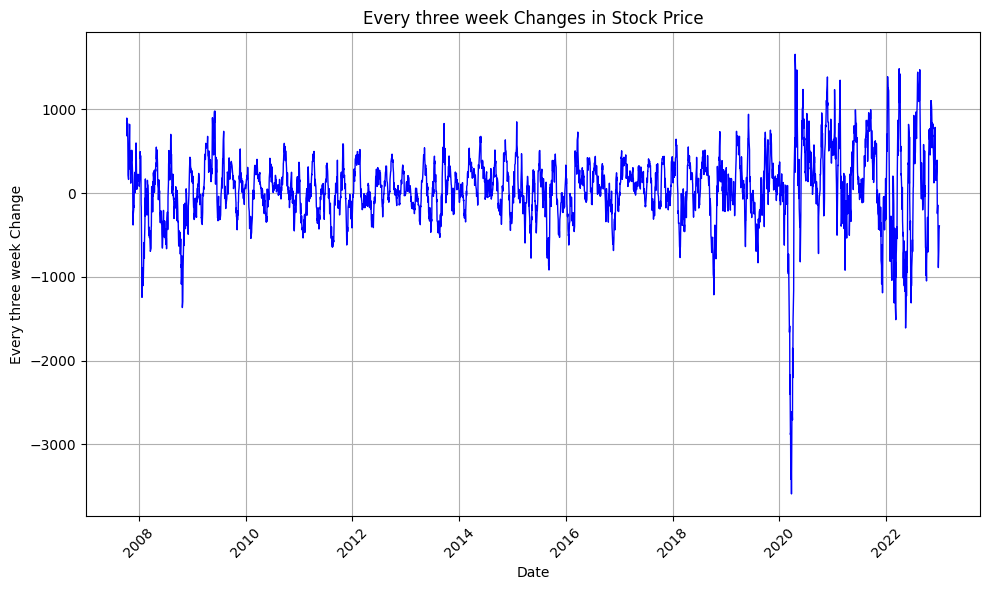

In [ ]:

# Plot the every three week changes
plt.figure(figsize=(10, 6))
plt.plot(stock['Close'].diff(15), color='blue', linestyle='-',linewidth=1)
plt.title('Every three week Changes in Stock Price')
plt.xlabel('Date')
plt.ylabel('Every three week Change')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

[*********************100%%**********************]  1 of 1 completed


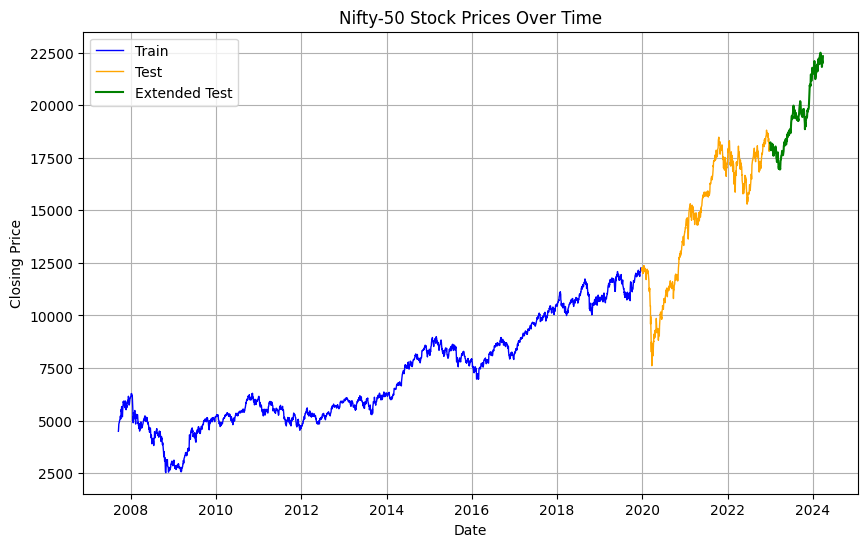

In [ ]:
# Visualizing the train - test and extended test split (which is not part of original datset)
split_index = int(len(stock) * 0.8)
stock_ext = yf.download("^NSEI", start='2023-01-02', end='2024-04-01')

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(stock["Close"].iloc[:split_index], label='Train', color='blue', linewidth=1)
plt.plot(stock["Close"].iloc[split_index:], label='Test', color='orange', linewidth=1)
plt.plot(stock_ext["Close"], label='Extended Test', color='green')
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Nifty-50 Stock Prices Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Removing volumne column
stock.drop(['Volume'], axis=1, inplace=True)

<Axes: >

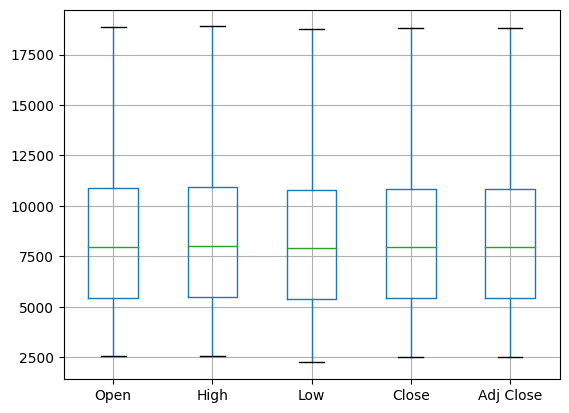

In [ ]:
# Plotting the boxplot to identify the outliers
stock.boxplot()

In [ ]:
#Function to evaluate the model
def model_evaluate(y_test,y_pred,model_name):
  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  print(f"{model_name} - Mean Squared Error: {mse}")
  print(f"{model_name} - Mean Absolute Error: {mae}")
  print(f"{model_name} - R-squared: {r2}")
  print(f"{model_name} - Mean absolute percentage error: {mape}")

In [ ]:
# Function to show the Autual vs Predicted graph
def show_graph(y_test,y_pred,model):
  y_pred = pd.DataFrame(y_pred)
  y_pred.index = y_test.index
  plt.plot(y_test, label='Actual')
  plt.plot(y_pred, label='Predicted')
  plt.title(f'{model} - Actual vs Predicted')
  plt.legend()
  plt.show()

In [ ]:
# Function to create lag feature
def create_lag_and_target(data, lag_days, target_days):
    """
    Create lagged features and target for stock price prediction."""

    # Create lagged features
    for i in range(1, lag_days + 1):
        data[f'close_{i}'] = data['Close'].shift(i)

    # Create target for the specified future day
    data['Target'] = data['Close'].shift(-target_days)

    # Drop rows with NaN values introduced by lagging
    data = data.dropna()

    return data

In [ ]:
#PCA to analyze the data
def pca(data,component):
  # Standardize the features (important for PCA)
  scaler = RobustScaler()
  scaled_features = scaler.fit_transform(data)

  # Initialize PCA with the desired number of components
  pca = PCA(n_components=component)

  # Fit PCA to the scaled features
  pca.fit(scaled_features)

  # Transform the original features to the PCA space
  pca_features = pca.transform(scaled_features)

  # Create a DataFrame to store the principal components
  pca_df = pd.DataFrame(data=pca_features, columns=[f'P_{i}' for i in range(1, component + 1)])

  print("Component explaining entire dataset - " + str(pca.explained_variance_ratio_))
  print("Variable extracted - " + str(pca.explained_variance_))
  return pca_df

In [ ]:
# Assuming 'df' is your DataFrame with a 'Close' column
# and you want to create a lag of 40 days and predict the 50th day close price
data = create_lag_and_target(stock, lag_days=15, target_days=5)

In [ ]:
data

,Open,High,Low,Close,Adj Close,close_1,close_2,close_3,close_4,close_5,...,close_7,close_8,close_9,close_10,close_11,close_12,close_13,close_14,close_15,Target
Date,,,,,,,,,,,,,,,,,,,,,
2007-10-09,5062.649902,5348.700195,5000.950195,5327.250000,5327.250000,5085.100098,5185.850098,5208.649902,5210.799805,5068.950195,...,5000.549805,4940.500000,4938.850098,4932.200195,4837.549805,4747.549805,4732.350098,4546.200195,4494.649902,5668.049805
2007-10-10,5328.149902,5454.700195,5328.149902,5441.450195,5441.450195,5327.250000,5085.100098,5185.850098,5208.649902,5210.799805,...,5021.350098,5000.549805,4940.500000,4938.850098,4932.200195,4837.549805,4747.549805,4732.350098,4546.200195,5559.299805
2007-10-11,5438.899902,5532.750000,5424.250000,5524.850098,5524.850098,5441.450195,5327.250000,5085.100098,5185.850098,5208.649902,...,5068.950195,5021.350098,5000.549805,4940.500000,4938.850098,4932.200195,4837.549805,4747.549805,4732.350098,5351.000000
2007-10-12,5525.299805,5549.299805,5402.600098,5428.250000,5428.250000,5524.850098,5441.450195,5327.250000,5085.100098,5185.850098,...,5210.799805,5068.950195,5021.350098,5000.549805,4940.500000,4938.850098,4932.200195,4837.549805,4747.549805,5215.299805
2007-10-15,5428.350098,5682.649902,5419.899902,5670.399902,5670.399902,5428.250000,5524.850098,5441.450195,5327.250000,5085.100098,...,5208.649902,5210.799805,5068.950195,5021.350098,5000.549805,4940.500000,4938.850098,4932.200195,4837.549805,5184.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-19,18288.099609,18431.650391,18244.550781,18420.449219,18420.449219,18269.000000,18414.900391,18660.300781,18608.000000,18497.150391,...,18609.349609,18560.500000,18642.750000,18701.050781,18696.099609,18812.500000,18758.349609,18618.050781,18562.750000,18014.599609
2022-12-20,18340.300781,18404.900391,18202.650391,18385.300781,18385.300781,18420.449219,18269.000000,18414.900391,18660.300781,18608.000000,...,18496.599609,18609.349609,18560.500000,18642.750000,18701.050781,18696.099609,18812.500000,18758.349609,18618.050781,18132.300781
2022-12-21,18435.150391,18473.349609,18162.750000,18199.099609,18199.099609,18385.300781,18420.449219,18269.000000,18414.900391,18660.300781,...,18497.150391,18496.599609,18609.349609,18560.500000,18642.750000,18701.050781,18696.099609,18812.500000,18758.349609,18122.500000


In [ ]:
data.reset_index(drop=True, inplace=True)
# data.drop(['Volume','Close'],axis=1,inplace=True)

In [ ]:
pca(data,3)

Component explaining entire dataset - [9.97662181e-01 1.48555704e-03 3.11521385e-04]
Variable extracted - [1.11074543e+01 1.65394231e-02 3.46831785e-03]


,P_1,P_2,P_3
0,-3.056535,-0.193682,-0.025166
1,-2.989909,-0.209296,-0.006046
2,-2.943983,-0.201242,-0.002786
3,-2.922032,-0.181494,-0.019774
4,-2.874101,-0.188080,-0.014908
...,...,...,...
3722,8.360408,0.178392,-0.040282
3723,8.355868,0.182854,-0.014607
3724,8.335955,0.197474,-0.006734
3725,8.294410,0.215246,-0.010298


In [ ]:
data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
close_1      0
close_2      0
close_3      0
close_4      0
close_5      0
close_6      0
close_7      0
close_8      0
close_9      0
close_10     0
close_11     0
close_12     0
close_13     0
close_14     0
close_15     0
Target       0
dtype: int64

In [ ]:
data.reset_index(drop=True, inplace=True)

In [ ]:
# 'Close','Target','Open','High','Low','Adj Close'
feature_columns = data.drop(['Close','Target'],axis=1)
print(feature_columns.columns)

Index(['Open', 'High', 'Low', 'Adj Close', 'close_1', 'close_2', 'close_3',
       'close_4', 'close_5', 'close_6', 'close_7', 'close_8', 'close_9',
       'close_10', 'close_11', 'close_12', 'close_13', 'close_14', 'close_15'],
      dtype='object')


In [ ]:
y = data['Target']
X = data[feature_columns.columns] #

In [ ]:
X.isnull().sum()

Open         0
High         0
Low          0
Adj Close    0
close_1      0
close_2      0
close_3      0
close_4      0
close_5      0
close_6      0
close_7      0
close_8      0
close_9      0
close_10     0
close_11     0
close_12     0
close_13     0
close_14     0
close_15     0
dtype: int64

In [ ]:
y.isnull().sum()

0

In [ ]:
split_index = int(len(X) * 0.8)

# Split the data
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

<Axes: >

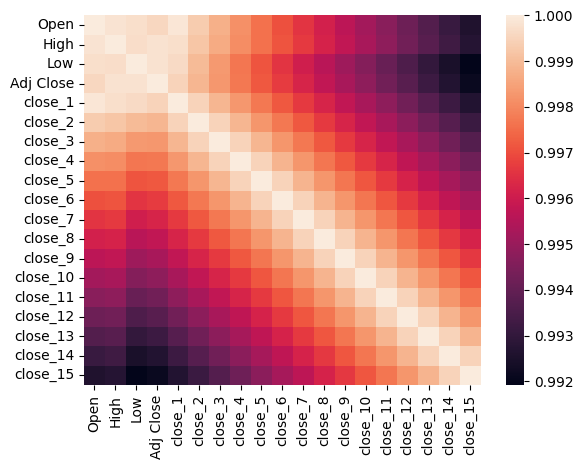

In [ ]:
sns.heatmap(X_train.corr())

In [ ]:
pca = PCA(n_components=4)

In [ ]:
linear_reg_pipeline = Pipeline([
    # ('pca',pca),
    ('robust', RobustScaler()),
    ('MinMax', MinMaxScaler()),
    ('linear_reg', LinearRegression())
])

# Fit the pipeline on the training data
linear_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=10)), ('robust', RobustScaler()),
                ('MinMax', MinMaxScaler()),
                ('linear_reg', LinearRegression())])

In [ ]:
y_pred = linear_reg_pipeline.predict(X_test)

In [ ]:
linear_reg_pipeline.score(X_test,y_test)

0.9809676949192352

In [ ]:
model_evaluate(y_test,y_pred,'Linear Regression')

Linear Regression - Mean Squared Error: 159671.14339429987
Linear Regression - Mean Absolute Error: 302.0276740161441
Linear Regression - R-squared: 0.9809676949192352
Linear Regression - Mean absolute percentage error: 0.021917722678579252


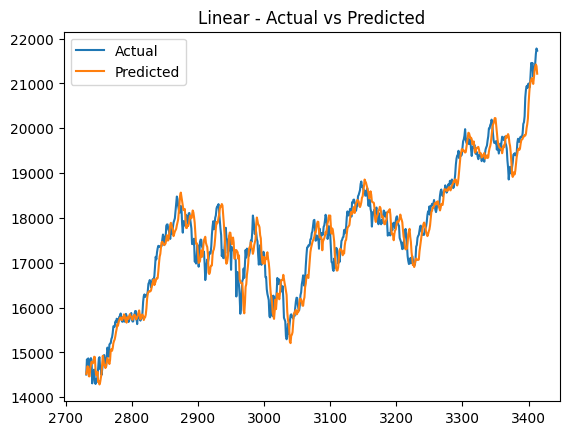

In [ ]:
show_graph(y_test,y_pred,'Linear')

[*********************100%%**********************]  1 of 1 completed


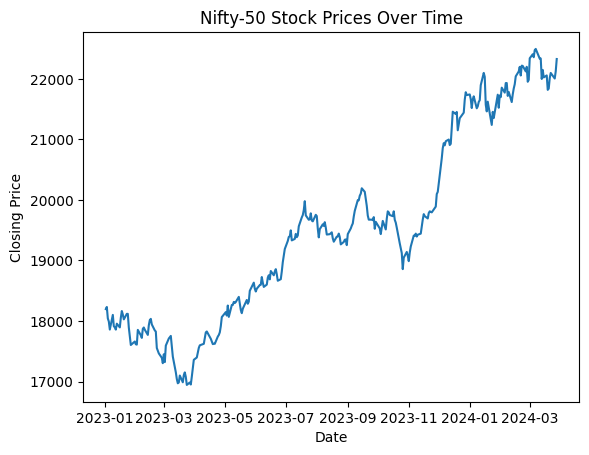

Index(['Open', 'High', 'Low', 'Adj Close', 'close_1', 'close_2', 'close_3',
       'close_4', 'close_5', 'close_6', 'close_7', 'close_8', 'close_9',
       'close_10', 'close_11', 'close_12', 'close_13', 'close_14', 'close_15'],
      dtype='object')


In [ ]:
## Real test

# Download the data from Yahoo Finance
test_stock = yf.download("^NSEI", start='2023-01-02', end='2024-04-01')

# Create a line plot of stock prices over time
plt.plot(test_stock["Close"])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title(f"Nifty-50 Stock Prices Over Time")
plt.show()

data_test = create_lag_and_target(test_stock, lag_days=15, target_days=5)
data_test.reset_index(drop=True, inplace=True)
feature_columns_test = data_test.drop(['Volume','Close','Target'],axis=1) # 'Close','Target','Open','High','Low','Adj Close'
print(feature_columns_test.columns)

y_real_test = data_test['Target']
X_Real_test = data_test[feature_columns_test.columns]

In [ ]:
y_pred_T = linear_reg_pipeline.predict(X_Real_test)
linear_reg_pipeline.score(X_Real_test,y_real_test)

0.9604475166224326

In [ ]:
model_evaluate(y_real_test,y_pred_T,'Linear Regression')

Linear Regression - Mean Squared Error: 95985.72880573674
Linear Regression - Mean Absolute Error: 245.2159320558402
Linear Regression - R-squared: 0.9604475166224326
Linear Regression - Mean absolute percentage error: 0.012542191827243638


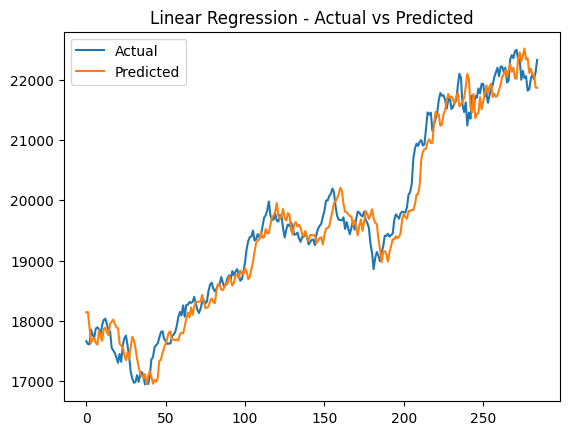

In [ ]:
show_graph(y_real_test,y_pred_T,'Linear Regression')

In [ ]:
# X_Real_test['Target'] = y_real_test
# X_Real_test['Predicted'] = y_pred_T
# X_Real_test

<ipython-input-112-b6d12b7d4a1b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Real_test['Target'] = y_real_test
<ipython-input-112-b6d12b7d4a1b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Real_test['Predicted'] = y_pred_T


,Open,High,Low,Adj Close,close_1,close_2,close_3,close_4,close_5,close_6,...,close_8,close_9,close_10,close_11,close_12,close_13,close_14,close_15,Target,Predicted
0,18118.449219,18162.599609,18063.449219,18118.550781,18027.650391,18107.849609,18165.349609,18053.300781,17894.849609,17956.599609,...,17895.699219,17914.150391,18101.199219,17859.449219,17992.150391,18042.949219,18232.550781,18197.449219,17662.150391,18139.817626
1,18183.949219,18201.250000,18078.650391,18118.300781,18118.550781,18027.650391,18107.849609,18165.349609,18053.300781,17894.849609,...,17858.199219,17895.699219,17914.150391,18101.199219,17859.449219,17992.150391,18042.949219,18232.550781,17616.300781,18148.284810
2,18093.349609,18100.599609,17846.150391,17891.949219,18118.300781,18118.550781,18027.650391,18107.849609,18165.349609,18053.300781,...,17956.599609,17858.199219,17895.699219,17914.150391,18101.199219,17859.449219,17992.150391,18042.949219,17610.400391,17901.722704
3,17877.199219,17884.750000,17493.550781,17604.349609,17891.949219,18118.300781,18118.550781,18027.650391,18107.849609,18165.349609,...,17894.849609,17956.599609,17858.199219,17895.699219,17914.150391,18101.199219,17859.449219,17992.150391,17854.050781,17633.835463
4,17541.949219,17709.150391,17405.550781,17648.949219,17604.349609,17891.949219,18118.300781,18118.550781,18027.650391,18107.849609,...,18053.300781,17894.849609,17956.599609,17858.199219,17895.699219,17914.150391,18101.199219,17859.449219,17764.599609,17700.066036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,21982.550781,22204.599609,21917.500000,22146.650391,21997.699219,22335.699219,22332.650391,22493.550781,22474.050781,22356.300781,...,22338.750000,21982.800781,21951.150391,22198.349609,22122.050781,22212.699219,22217.449219,22055.050781,22011.949219,22180.958498
281,22064.849609,22120.900391,21931.699219,22023.349609,22146.650391,21997.699219,22335.699219,22332.650391,22493.550781,22474.050781,...,22405.599609,22338.750000,21982.800781,21951.150391,22198.349609,22122.050781,22212.699219,22217.449219,22096.750000,22075.609654
282,21990.099609,22123.699219,21916.550781,22055.699219,22023.349609,22146.650391,21997.699219,22335.699219,22332.650391,22493.550781,...,22356.300781,22405.599609,22338.750000,21982.800781,21951.150391,22198.349609,22122.050781,22212.699219,22004.699219,22078.980672
283,21946.449219,21978.300781,21793.099609,21817.449219,22055.699219,22023.349609,22146.650391,21997.699219,22335.699219,22332.650391,...,22474.050781,22356.300781,22405.599609,22338.750000,21982.800781,21951.150391,22198.349609,22122.050781,22123.650391,21868.346928


In [ ]:
time_split = TimeSeriesSplit(n_splits=3)

In [ ]:
# Create a pipeline with PolynomialFeatures
pipeline = Pipeline([
    ('pca',pca),
    ('scaler', StandardScaler()),
    ('MinMax', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(include_bias=False)),
    ('linear_reg', LinearRegression())
])

# # Specify the degrees to be searched
param_grid = {
    'poly_features__degree': [2,3,4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid,cv=time_split,scoring='neg_mean_squared_error', return_train_score=True)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best degree from the grid search
best_degree = grid_search.best_params_['poly_features__degree']

# Plot the data and the polynomial regression curve
y_pred = grid_search.predict(X_test)

In [ ]:
print("Best Degree " + str(best_degree))
print(-grid_search.cv_results_['mean_test_score'])

Best Degree 2
[   48972.65058344   447280.72667116 10225817.8553825 ]


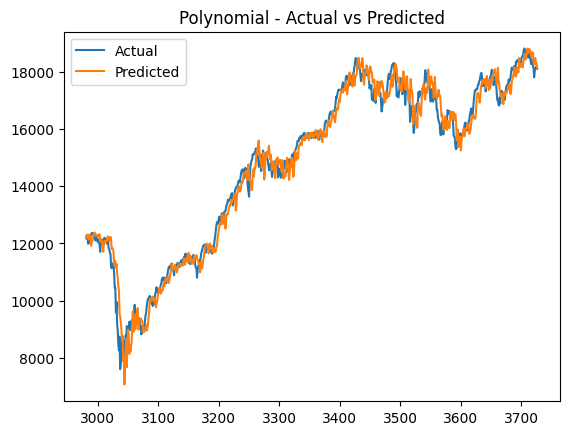

In [ ]:
show_graph(y_test,y_pred,'Polynomial')

In [ ]:
model_evaluate(y_test,y_pred,'Polynomial regression')

Polynomial regression - Mean Squared Error: 188614.42863737908
Polynomial regression - Mean Absolute Error: 323.1308649541136
Polynomial regression - R-squared: 0.9775177450843701
Polynomial regression - Mean absolute percentage error: 0.023535668884633636


In [ ]:
y_pred_T = grid_search.predict(X_Real_test)
grid_search.score(X_Real_test,y_real_test)

-115791.49818653813

In [ ]:
model_evaluate(y_real_test,y_pred_T,'Linear Regression')

Linear Regression - Mean Squared Error: 115791.49818653813
Linear Regression - Mean Absolute Error: 266.95122224624276
Linear Regression - R-squared: 0.9522862266685945
Linear Regression - Mean absolute percentage error: 0.013611137364299964


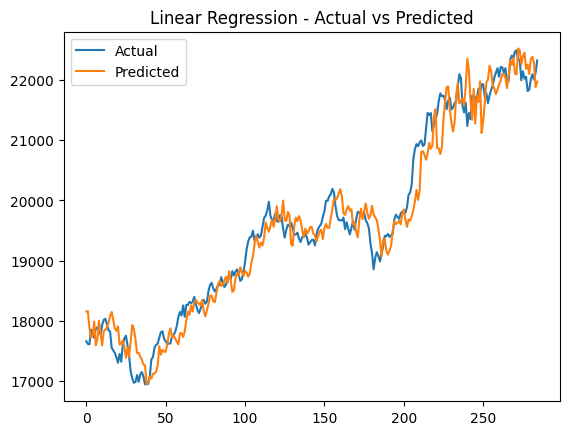

In [ ]:
show_graph(y_real_test,y_pred_T,'Linear Regression')

In [ ]:
# Create a pipeline with PolynomialFeatures, MinMaxScaler, and Elastic Net Regression
elastic_net_pipeline = Pipeline([
    ('pca',pca),
    ('scaler', StandardScaler()),
    ('MinMax', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(include_bias=False)),
    ('elastic_net_reg', ElasticNet())
])

# Specify the degrees and alpha to be searched
param_grid = {
    'poly_features__degree': [2, 3],
    'elastic_net_reg__alpha': np.logspace(-4, 2, 7),  # Adjust the range as needed
    'elastic_net_reg__l1_ratio': [0,0.1,0.3, 0.5,0.7, 0.9,1]  # Adjust the ratios as needed
}

scoring = ['neg_mean_squared_error', 'accuracy']

# Create the GridSearchCV object
elastic_net_grid_search = GridSearchCV(elastic_net_pipeline, param_grid,scoring='neg_mean_squared_error', cv=time_split, return_train_score=True)

# Perform the grid search
elastic_net_grid_search.fit(X_train, y_train)

# Get the best degree, alpha, and l1_ratio from the grid search
best_degree = elastic_net_grid_search.best_params_['poly_features__degree']
best_alpha = elastic_net_grid_search.best_params_['elastic_net_reg__alpha']
best_l1_ratio = elastic_net_grid_search.best_params_['elastic_net_reg__l1_ratio']

print(f"Best Degree - {best_degree}")
print(f"Best Alpha - {best_alpha}")
print(f"Best L Ratio - {best_l1_ratio}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.374e+07, tolerance: 6.762e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.260e+07, tolerance: 1.083e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Best Degree - 2
Best Alpha - 0.1
Best L1 Ratio - 1


In [ ]:
y_pred = elastic_net_grid_search.predict(X_test)

In [ ]:
model_evaluate(y_test,y_pred,'ElasticNet regression')

ElasticNet regression - Mean Squared Error: 163496.13231137025
ElasticNet regression - Mean Absolute Error: 303.81011973318346
ElasticNet regression - R-squared: 0.9805117681033266
ElasticNet regression - Mean absolute percentage error: 0.02200998001337485


In [ ]:
y_pred_T = grid_search.predict(X_Real_test)
grid_search.score(X_Real_test,y_real_test)

-115791.49818653813

In [ ]:
model_evaluate(y_real_test,y_pred_T,'Linear Regression')

Linear Regression - Mean Squared Error: 115791.49818653813
Linear Regression - Mean Absolute Error: 266.95122224624276
Linear Regression - R-squared: 0.9522862266685945
Linear Regression - Mean absolute percentage error: 0.013611137364299964


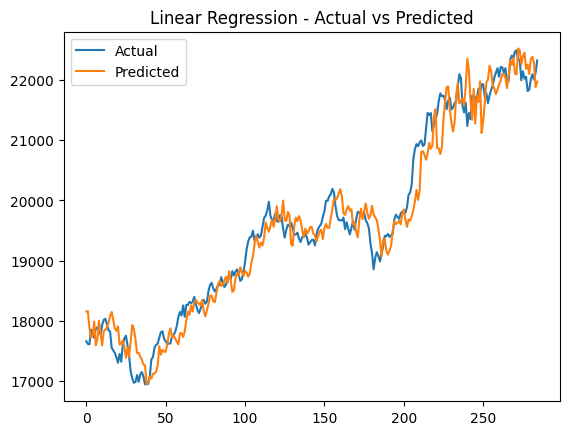

In [ ]:
show_graph(y_real_test,y_pred_T,'Linear Regression')